# Rides

Here is where we do analysis on all the trip data of Citibikes.

In [118]:
import pandas as pd
import pickle

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Loading the stations data

In [161]:
class Stations:
    def __init__(self, path):
        self.stations = pickle.load(open(path, "rb"))
       
    # Returns the row that holds information about station that has given station_id
    def get_by_id(self, station_id):
        res = self.stations[self.stations.id == station_id]
        if res.empty:
            raise Exception('Empty Result')
        else:
            return res
    
    # returns all the stations ids as a list
    def get_ids(self):
        return self.stations.id
    
    # returns the head of the table
    def head(self, count=5):
        return self.stations.head(count)
    
    # returns a DataFrame that contain all the unique areas and their respective area_id
    def get_areas(self):
        return self.stations[["area", "area_id"]].drop_duplicates()[:-1]
    
    # returns the entire DataFrame as it is
    def get_stations(self):
        self.stations

In [141]:
stations = Stations("../data/augmented_stations.pickle")

In [142]:
stations.head()

,id,latitude,longitude,stationName,city,neighborhood,neighborhood_id,area,area_id
0,72,40.767272,-73.993929,W 52 St & 11 Ave,New York,All Midtown,119,Midtown West,124
1,79,40.719116,-74.006667,Franklin St & W Broadway,New York,All Downtown,102,Tribeca,105
2,82,40.711174,-74.000165,St James Pl & Pearl St,New York,Chinatown,110,Two Bridges,111
3,83,40.683826,-73.976323,Atlantic Ave & Fort Greene Pl,Brooklyn,Brooklyn,300,Fort Greene,304
4,116,40.741776,-74.001497,W 17 St & 8 Ave,New York,All Downtown,102,Chelsea,115



## Loading Sample Citibike Trip Data

In [143]:
trip_data = pd.read_csv("../data/trip-data/201509-citibike-tripdata.csv")

In [144]:
trip_data.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id', u'start station name', u'start station latitude', u'start station longitude', u'end station id', u'end station name', u'end station latitude', u'end station longitude', u'bikeid', u'usertype', u'birth year', u'gender'], dtype='object')

## Obtain the Popular Stations

This includes the number of times a station was either the source or destination in a trip taken.

In [162]:
# Number of times a station was the start station. Holds a dict with the station_id
# as its key and the number of times the station was the starting point of the trip
# as the value.
station_outgoing = trip_data.groupby("start station id").size().to_dict()

# Number of times a station was the end station. Again a dict similar to above.
station_incoming = trip_data.groupby("end station id").size().to_dict()

**create an interface to access traffic count in data, given the id**

In [146]:
def get_traffic(data, id):
    return data[id] if id in data else 0

In [147]:
get_traffic(station_outgoing, 3002)

7977

**creating final station counts as a python dict**

In [164]:
station_traffic = dict()

for station_id in stations.get_ids():
    station_traffic[station_id] = get_traffic(station_outgoing, station_id) + \
                                  get_traffic(station_incoming, station_id)

**obtaining the popular stations by sorting the dict based on the total traffic at the station**

In [150]:
popular_stations = sorted(station_traffic, key= lambda e: station_traffic[e], reverse=True)

In [166]:
for station_id in popular_stations[:10]:
    info = stations.get_by_id(station_id=station_id)
    station_name = info.stationName.item()
    print `station_id` + ", " + station_name + " : " + `station_traffic[station_id]`

521, 8 Ave & W 31 St : 26798
519, Pershing Square North : 25930
293, Lafayette St & E 8 St : 22722
426, West St & Chambers St : 21267
435, W 21 St & 6 Ave : 20679
497, E 17 St & Broadway : 20625
151, Cleveland Pl & Spring St : 18298
285, Broadway & E 14 St : 18135
368, Carmine St & 6 Ave : 16945
284, Greenwich Ave & 8 Ave : 16662


<Container object of 508 artists>

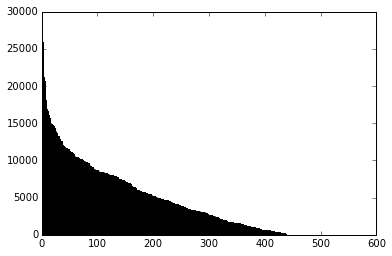

In [167]:
plt.bar(range(len(popular_stations)), [station_traffic[id] for id in popular_stations])

## Obtain the Popular Areas

Since we have already found out the traffic at every station, we will use that data to obtain the traffic for every area, which is nothing but the sum of traffic of all the stations in the area.

In [169]:
def get_area_traffic(station_traffic):
    area_traffic = dict()
    for station_id in station_traffic.keys():
        try:
            info = stations.get_by_id(station_id)
            area_id = info.area_id.item()

            if area_id not in area_traffic:
                area_traffic[area_id] = station_traffic[station_id]
            else:
                area_traffic[area_id] += station_traffic[station_id] 
        except:
            pass
    
    return area_traffic

In [170]:
area_outgoing = get_area_traffic(station_outgoing)
area_incoming = get_area_traffic(station_incoming)

In [171]:
areas = stations.get_areas()
areas.head(5)

,area,area_id
0,Midtown West,124
1,Tribeca,105
2,Two Bridges,111
3,Fort Greene,304
4,Chelsea,115


In [173]:
area_traffic = dict()
for area_id in areas.area_id:
    area_traffic[area_id] = get_traffic(area_incoming, area_id) + \
                            get_traffic(area_outgoing, area_id)

In [174]:
popular_areas = sorted(area_traffic, key=lambda e: area_traffic[e], reverse=True)

In [177]:
for area_id in popular_areas[:10]:
    info = areas[areas.area_id == area_id]
    area_name = info.area.item()
    print area_id, area_name, area_traffic[area_id]

117 East Village 196376
124 Midtown West 186607
120 Midtown 141882
115 Chelsea 140411
116 Greenwich Village 125348
157 West Village 123568
122 Midtown South 116974
109 Lower East Side 95789
158 Flatiron 95538
105 Tribeca 86540


<Container object of 65 artists>

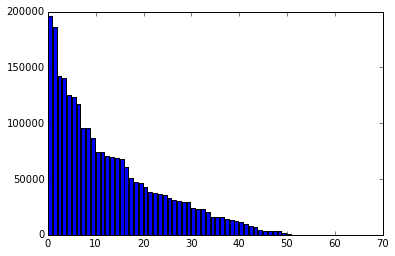

In [159]:
plt.bar(range(len(popular_areas)), [area_traffic[id] for id in popular_areas])